# 【智慧生活】─觸碰偵測
### NTUST CS5149701 人工智慧與邊緣運算實務 期末專題 DEMO
學號 : M11007319 <br>姓名 : 莊士頡

---

## 摘要說明
本系統為解決騷擾事件發生時，被害者會因為慌亂、恐懼等等負面情緒影響，抑或是事件過後才察覺不舒服，而未能在第一時間保存證據。

本系統利用了MediaPipe Pose、MediaPipe Multiple Hands結合了一Binary classification模型， 建構2 stage的多人動作辨識器，主要任務為辨識是否有人觸碰使用者，如果判定觸碰事件發生則觸發錄影並儲存影片，以此作為騷擾事件判斷依據。

---

此專案以圖片做DEMO，操作步驟包括：

1.   設定環境，下載測試圖片
2.   前置作業，模型設定
3.   展示推論結果

## 1. 設定環境，下載測試圖片

In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import cv2
import mediapipe as mp
import time
import pandas as pd
import torch
import torch.nn as nn
import copy
from google.colab.patches import cv2_imshow # 導入顯示OpenCV格式影像套件包

In [ ]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zPo8svzt6UIXv7e4DT8uSbDVusib3B-y' -O mymodule.zip
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bXWkAlTldpPpJAJRctG4W4VQrCa3E3bu' -O testing_img0.jpg
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1In4Ff8Kk-oWtZJGy4V33K-NdlLVcynsa' -O testing_img1.jpg

# https://drive.google.com/file/d/15mpk9pz3ES__b6kiXtnHQWEwEaFJyWkX/view?usp=sharing
# https://drive.google.com/file/d/1In4Ff8Kk-oWtZJGy4V33K-NdlLVcynsa/view?usp=sharing

!unrar x '/content/mymodule.zip' '/content'

--2022-06-07 10:49:54--  https://docs.google.com/uc?export=download&id=1zPo8svzt6UIXv7e4DT8uSbDVusib3B-y
Resolving docs.google.com (docs.google.com)... 74.125.195.101, 74.125.195.100, 74.125.195.113, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0o-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/el2u6sqkciek0bu7dgcp2huvstacnn1r/1654598925000/03309802504738694405/*/1zPo8svzt6UIXv7e4DT8uSbDVusib3B-y?e=download [following]
--2022-06-07 10:49:55--  https://doc-0o-8o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/el2u6sqkciek0bu7dgcp2huvstacnn1r/1654598925000/03309802504738694405/*/1zPo8svzt6UIXv7e4DT8uSbDVusib3B-y?e=download
Resolving doc-0o-8o-docs.googleusercontent.com (doc-0o-8o-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-0o-8o-docs.googleusercontent.com (doc-0o-8o-docs.goog

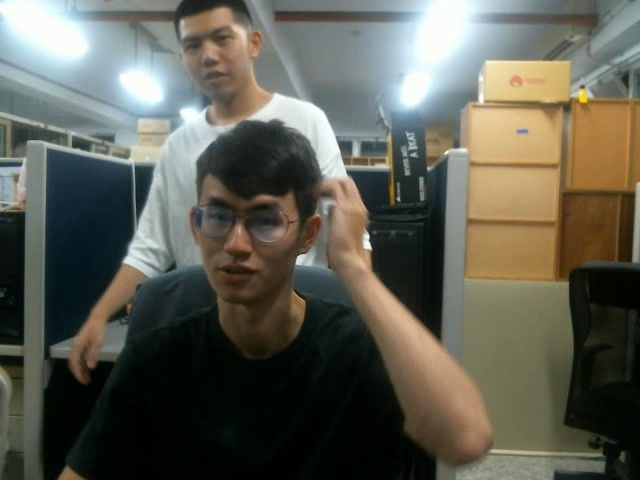

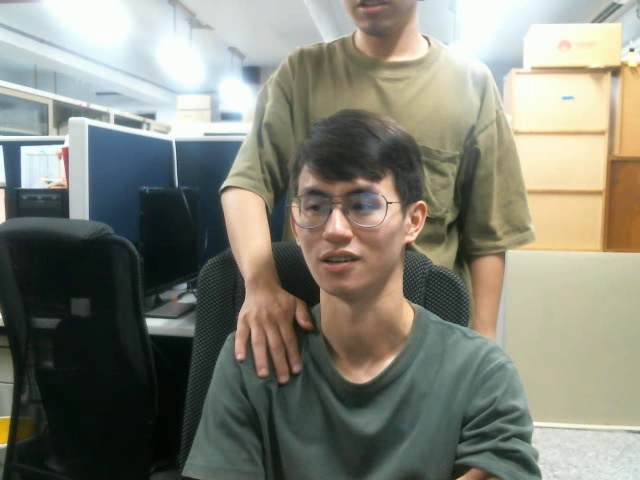

In [ ]:
img0 = cv2.imread('/content/testing_img0.jpg') # 讀入影像
cv2_imshow(img0) # 顯示輸入影像
img1 = cv2.imread('/content/testing_img1.jpg') # 讀入影像
cv2_imshow(img1) # 顯示輸入影像

## 2. 前置作業
此專題採用 [Mediapipe Hands](https://google.github.io/mediapipe/solutions/hands) 以及 [Mediapipe Pose](https://google.github.io/mediapipe/solutions/pose.html) 模組來提取人體關鍵點<br>
並整合一二元分類，在偵測完關鍵點後，進一步辨識是否有觸碰事件發生<br>

In [ ]:
POSE_POINT = 22
HAND_POINT = 11  # 0,2,4,6...

mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose  # Mediapipe 姿勢偵測
df = pd.DataFrame()
predict_result = ["No touching", "Touching"]
pose = mp_pose.Pose(
            static_image_mode=True,
            model_complexity=2,
            enable_segmentation=True,
            min_detection_confidence=0.5)
hands = mp_hands.Hands(
                static_image_mode=True,
                max_num_hands=4,
                min_detection_confidence=0.5)

In [ ]:
class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        # Number of input features is 12.
        self.layer_1 = nn.Linear(176, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_3 = nn.Linear(64, 32)
        self.layer_out = nn.Linear(32, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)
        self.batchnorm3 = nn.BatchNorm1d(32)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.relu(self.layer_3(x))
        x = self.batchnorm3(x)
        x = self.dropout(x)
        x = self.layer_out(x)

        return x

In [ ]:
m_state_dict = torch.load('/content/mymodule.pt')
new_m = BinaryClassification()
new_m.load_state_dict(m_state_dict)

<All keys matched successfully>

## 3. 展示推論結果
可以利用 "img0", "img1"進行測試，結果會直接print在左上角處

In [ ]:
copyImg = copy.deepcopy(img0)
pose_lst = [0.0] * POSE_POINT * 2
hand_lst = [0.0] * HAND_POINT * 3 * 4  # x,y,z * 4 hands
handResults = hands.process(copyImg)
poseResults = pose.process(copyImg)

if handResults.multi_hand_world_landmarks:
    for hands_id, handLms in enumerate(handResults.multi_hand_landmarks):
        for hid, hlm in enumerate(handLms.landmark):
            # 获取手指关节点
            if hid % 2 == 0:
                hand_lst[33 * hands_id + int(hid / 2)] = hlm.x
                hand_lst[33 * hands_id + int(hid / 2) + HAND_POINT] = hlm.y
                hand_lst[33 * hands_id + int(hid / 2) + 2 * HAND_POINT] = hlm.z
if poseResults.pose_landmarks:
    for pid, data_point in enumerate(poseResults.pose_landmarks.landmark):
        if pid >= POSE_POINT:
            break
        pose_lst[pid] = data_point.x * round(data_point.visibility, 0)
        pose_lst[pid + POSE_POINT] = data_point.y * round(data_point.visibility, 0)
ls = pose_lst + hand_lst

[0.3315967321395874, 0.3398746848106384, 0.3497057557106018, 0.3590514361858368, 0.3185339868068695, 0.3122211992740631, 0.30453991889953613, 0.38334187865257263, 0.3026770055294037, 0.3557355999946594, 0.32316678762435913, 0.47750797867774963, 0.2797876000404358, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12101554870605469, 0.08636927604675293, 0.08353722095489502, 0.08124136924743652, 0.0940355584025383, 0.09707236289978027, 0.10028016567230225, 0.08816606551408768, 0.1149400994181633, 0.1492515206336975, 0.15452255308628082, 0.2510989010334015, 0.2776939570903778, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:549: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


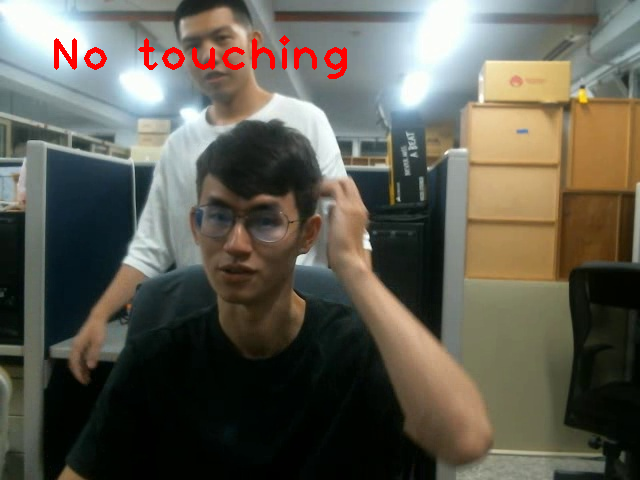

In [ ]:
input_data = torch.FloatTensor(ls)

new_m.eval()
y_test_pred = new_m(input_data.resize(1, 176))
y_test_pred = torch.sigmoid(y_test_pred)
y_pred_tag = torch.round(y_test_pred)
cv2.putText(copyImg, predict_result[int(y_pred_tag.item())], (50, 70), cv2.FONT_HERSHEY_PLAIN, 3, (0, 0, 255), 3)
cv2_imshow(copyImg)